# **Problem Statement & Solution Design**

### **Problem Statement:**

ABC Corporation lacks data-driven into their workforce demographics, compensation structure, and temporal hiring trends. HR decisions are made based on intuition rather than emperical evidence, leading to potential inefficiencies in salary distribution, age-based workforce planning, and category-wise resource allocation.

### **Desired Solution:**
A comprehensive HR Analytics Dashboard that provides:
1. Workforce demographics analysis
2. Compensation structure insights
3. Temporal hiring trends
4. Category-wise performance metrics
5. Interactive exploration capabilities

In [1]:
"""
10000-row dirty dataset generator
Matches the flaws in the 6-row example:
  – duplicate names
  – None / NaN / empty strings
  – negative ages
  – invalid dates
  – missing salaries
  – stray whitespace & mixed-case names
  – rare exotic Unicode
  – leading zeros in IDs
  – occasional extra columns (ragged CSV feel)
"""

import pandas as pd # Core data-frame library
import numpy as np # Numerical helpers (clip, stats)
from datetime import date, timedelta
import random
import warnings # Silence harmless warnings
warnings.filterwarnings('ignore') # Suppress pandas warnings

RNG = np.random.default_rng(42)
SIZE = 10000

# 1) ID: mostly sequential but with gaps and leading zeros
ids = list(range(1, SIZE + 1))
RNG.shuffle(ids)
ids = [f"{i:05d}" for i in ids]          # 00001, 00002 …

# 2) Names: common, rare, empty, None, Unicode, spaces
first = ["Alice", "Bob", "Charlie", "Diana", "Eve", "Frank", "Grace", None, "", "  ", "bob", "ALICE"]
last  = ["Smith", "Johnson", "Lee", "O'Connor", "van der Waal", "Михайлов", "🐼", None, ""]
names = [f"{RNG.choice(first)} {RNG.choice(last)}" for _ in range(SIZE)]
# sprinkle pure None
for i in RNG.choice(SIZE, size=300, replace=False):
    names[i] = None

# 3) Age: positives, negatives, NaN, floats
ages = RNG.normal(loc=35, scale=12, size=SIZE)
ages[RNG.random(SIZE) < 0.08] = np.nan
ages[RNG.random(SIZE) < 0.02] = RNG.integers(-10, 0)

# 4) Salary: missing, negatives, huge, cents
salaries = RNG.lognormal(mean=11, sigma=0.5, size=SIZE)
salaries[RNG.random(SIZE) < 0.07] = np.nan
salaries[RNG.random(SIZE) < 0.01] = -RNG.exponential(1000)
salaries = np.round(salaries, 2)

# 5) Date: valid, impossible, mis-formatted
start = date(2020, 1, 1)
def random_date():
    if RNG.random() < 0.05:
        return RNG.choice(["invalid", "2021-02-30", "13/45/2022", "", "N/A"])
    delta = timedelta(days=int(RNG.integers(0, 1500)))
    d = start + delta
    if RNG.random() < 0.10:
        return d.strftime("%d/%m/%Y")
    return str(d)

dates = [random_date() for _ in range(SIZE)]

# 6) Category: A B C plus garbage
cats = ["A", "B", "C", None, "", "a", "b", "🎲"]
categories = RNG.choice(cats, size=SIZE, p=[0.3, 0.3, 0.3, 0.03, 0.03, 0.02, 0.01, 0.01])

# 7) Build DataFrame
df = pd.DataFrame({
    "id": ids,
    "name": names,
    "age": ages,
    "salary": salaries,
    "date": dates,
    "category": categories
})

# 8) Extra dirt: duplicate rows, swapped columns, trailing spaces
df = pd.concat([df, df.sample(n=200, random_state=RNG)], ignore_index=True)   # 200 dupes
df["name"] = df["name"].astype(str).str.strip() + RNG.choice(["", " ", "  "], size=len(df))
df.iloc[RNG.choice(len(df), 50), 0] = ""   # blank ids
df.iloc[RNG.choice(len(df), 50), 2] = "thirty-five"  # string in age

# 9) Save
df.to_csv("messy_dataset.csv", index=False)
print("messy_dataset.csv created →", df.shape)
print(df.head(10))

messy_dataset.csv created → (10200, 6)
      id                name        age     salary        date category
0  08133          None Lee    16.741619  102784.00  2022-11-14        B
1           Diana Михайлов    43.415811   48330.35  2020-02-19        a
2  00720        Charlie None  28.195627  126557.90  2023-03-29        A
3  08238           bob Smith  39.515083   71411.52  2022-11-05        A
4  04556        ALICE Smith   45.646664  158614.65  2020-06-20        B
5  06652           Frank 🐼    38.934451        NaN  2022-06-23        B
6  05651       Diana Johnson  44.589521   43432.43  13/45/2022        B
7  09035           Alice 🐼    10.200329   53309.34  2024-01-10        A
8  01261  Alice van der Waal   29.08572   32652.40  2022-04-26        C
9  00645                Eve    48.23692   95124.50  2022-09-05        C


In [2]:
df.head(20)

,id,name,age,salary,date,category
0,08133,None Lee,16.741619,102784.00,2022-11-14,B
1,,Diana Михайлов,43.415811,48330.35,2020-02-19,a
2,00720,Charlie None,28.195627,126557.90,2023-03-29,A
3,08238,bob Smith,39.515083,71411.52,2022-11-05,A
4,04556,ALICE Smith,45.646664,158614.65,2020-06-20,B
5,06652,Frank 🐼,38.934451,NaN,2022-06-23,B
6,05651,Diana Johnson,44.589521,43432.43,13/45/2022,B
7,09035,Alice 🐼,10.200329,53309.34,2024-01-10,A
8,01261,Alice van der Waal,29.08572,32652.40,2022-04-26,C
9,00645,Eve,48.23692,95124.50,2022-09-05,C


In [3]:
df.tail(20)

,id,name,age,salary,date,category
10180,02162,Frank Smith,35.251923,37148.68,2021-12-17,a
10181,02381,Bob Михайлов,41.145279,57806.49,,B
10182,02105,Alice Johnson,NaN,NaN,2021-07-25,A
10183,03498,Eve Lee,45.42236,93277.63,2020-11-30,C
10184,08343,O'Connor,-6.0,39829.00,2020-05-31,C
10185,00826,Bob van der Waal,34.978204,38650.37,2023-11-01,B
10186,08588,Alice None,37.613011,60473.07,2023-05-28,B
10187,06544,bob None,NaN,79840.10,2021-04-30,B
10188,08446,bob O'Connor,28.817501,96273.21,2023-08-02,C
10189,06721,None,14.050043,52409.28,2020-10-18,C


In [4]:
df.dtypes

id           object
name         object
age          object
salary      float64
date         object
category     object
dtype: object

In [5]:
df.size

61200

In [6]:
df.shape

(10200, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10200 non-null  object 
 1   name      10200 non-null  object 
 2   age       9393 non-null   object 
 3   salary    9524 non-null   float64
 4   date      10200 non-null  object 
 5   category  9923 non-null   object 
dtypes: float64(1), object(5)
memory usage: 478.3+ KB


In [8]:
df.describe()

,salary
count,9524.000000
mean,66424.999071
std,36477.816459
min,-30.040000
25%,41873.285000
50%,58793.045000
75%,82240.572500
max,392309.920000


In [9]:
df.describe(include='all')

,id,name,age,salary,date,category
count,10200,10200,9393.0,9524.000000,10200,9923
unique,9954,294,8971.0,NaN,2164,7
top,,None,-6.0,NaN,13/45/2022,B
freq,50,197,201.0,NaN,119,3111
mean,NaN,NaN,NaN,66424.999071,NaN,NaN
std,NaN,NaN,NaN,36477.816459,NaN,NaN
min,NaN,NaN,NaN,-30.040000,NaN,NaN
25%,NaN,NaN,NaN,41873.285000,NaN,NaN
50%,NaN,NaN,NaN,58793.045000,NaN,NaN
75%,NaN,NaN,NaN,82240.572500,NaN,NaN


In [10]:
df.isnull().sum()

id            0
name          0
age         807
salary      676
date          0
category    277
dtype: int64

In [11]:
df.isna().sum()

id            0
name          0
age         807
salary      676
date          0
category    277
dtype: int64

In [12]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
10195    False
10196    False
10197     True
10198    False
10199    False
Length: 10200, dtype: bool

In [13]:
df.duplicated().sum()

56

In [14]:
duplicate_rows_df = df[df.duplicated()]
print(duplicate_rows_df)

          id                  name        age     salary        date category
10006  04280  Charlie van der Waal  27.506392   71272.04  2021-06-11        B
10007  05113       Charlie Smith          NaN   72510.83  2021-01-10        C
10009  07007          Grace None          NaN        NaN  2021-11-01        A
10011  01735   Grace van der Waal         NaN  181071.86  2020-12-11     None
10013  04871      Alice Михайлов    37.889299   40807.27  2020-12-05        C
10015  02144      Frank O'Connor    17.876179   35368.76  2020-01-16        C
10016  08127         None O'Connor  51.103991   70605.62  2021-12-09        B
10019  06045              None 🐼    16.329463  109945.56  2023-01-04        B
10021  01918         Bob Johnson    38.242005   49217.47  2022-03-08        C
10023  08210           bob Smith    32.521784   27080.42  24/02/2022        C
10030  09574                ALICE    24.21752     -30.04  2022-09-18        C
10031  05160           Eve Johnson   6.870109   66070.84  07/10/

# ETL PIPELINE

In [15]:
import sqlite3 # SQLite connector (for DB source)
from datetime import datetime # Datetime filler
import pandas.api.types as pd_types # Type-checking utilities
import unicodedata # Unicode normalisation (NFKC)
import re # Regex for pattern removal
from pathlib import Path # OS-independent 
from tqdm import tqdm # progress bars


pd.set_option('display.max_columns', None) # show all columns in .info()


def etl_pipeline(
    source_path: str, # Path to csv or SQLite DB
    is_csv: bool = True, # True - CSV, False - SQLite
    table_name: str = None, # Required when csv=False
    datetime_columns: list = None, # Columns to parse as dates
    numeric_columns_for_outliers: list = None, # Clip outliers
    numeric_columns_for_standardization: list = None, # Z-score
    numeric_prep_columns: list = None, # Coerce to numeric
    categorical_columns: list = None, # used or not used directly
    output_path: str = 'cleaned_data.csv', # where to save and the name to save file
    fill_datetime_na_with: datetime = None, # fallback date 
    type_conversions: dict = None, # convert dtype
    normalize_text: bool = True, # string normalisation
    remove_patterns: list = None, # regex patterns to strip
    auto_create_table: bool = False,  #  create DB from csv
    source_csv_for_create: str = None # CSV path
):
    """
    ETL pipeline with optional text-pattern removal, outlier clipping, standardisation, etc.
    All list/dict parameters default to empty so we can safely pass None.
    """
    # Normalise mutable defaults
    datetime_columns = datetime_columns or []
    numeric_columns_for_outliers = numeric_columns_for_outliers or []
    numeric_columns_for_standardization = numeric_columns_for_standardization or []
    numeric_prep_columns = numeric_prep_columns or []
    categorical_columns = categorical_columns or []
    type_conversions = type_conversions or {}
    remove_patterns = remove_patterns or []

    # 0.  Auto-create SQLite table if requested
    if not is_csv and auto_create_table and source_csv_for_create:
        if Path(source_path).exists() and not auto_create_table:
            pass   # DB already exists – don’t overwrite
        else:
            df_seed = pd.read_csv(source_csv_for_create)
            conn = sqlite3.connect(source_path)
            df_seed.to_sql(table_name, conn, if_exists='replace', index=False)
            conn.close()

    #  1. Extraction 
    if is_csv:
        df = pd.read_csv(
            source_path,
            keep_default_na=False,
            na_values=['', 'nan', 'NULL', 'NaN', 'NONE', 'None', '🎲', 'NAN'],
            low_memory=False
        )
    else:
        if table_name is None:
            raise ValueError("table_name required for SQLite.")
        # Guard against SQL injection
        conn = sqlite3.connect(source_path)
        quoted_name = conn.execute("SELECT quote(?)", (table_name,)).fetchone()[0]
        df = pd.read_sql_query(f"SELECT * FROM {quoted_name}", conn)
        conn.close()

    print("Original DataFrame info:")
    df.info()
    print("\nFirst 10 rows (original):")
    print(df.head(10))

    #  2. Transformation 

    # 2a. Unicode normalisation + trim
    obj_cols = df.select_dtypes(include=['object']).columns
    if normalize_text:
        df[obj_cols] = df[obj_cols].apply(
            lambda s: s.apply(lambda x: unicodedata.normalize('NFKC', str(x)).strip())
        )
    df[obj_cols] = df[obj_cols].replace('nan', 'Unknown')

    # 2b. Vectorised pattern removal
    if remove_patterns:
        big_pat = '|'.join(f'(?:{re.escape(p)})' for p in remove_patterns)
        df[obj_cols] = df[obj_cols].apply(
            lambda s: s.str.replace(big_pat, '', regex=True).str.strip()
        )

    # 2c. Coerce numeric
    for col in numeric_prep_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # 2d. Datetime
    for col in datetime_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # 2e. Missing-value imputation
    for col in df.columns:
        if col in numeric_prep_columns:
            df[col] = df[col].fillna(df[col].median())
        elif pd_types.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].fillna(fill_datetime_na_with or pd.Timestamp('2025-11-02'))
        else:
            if col == 'name':
                df[col] = df[col].replace({'None': 'Unknown', '': 'Unknown'}).fillna('Unknown')
            elif col == 'category':
                #  1. Clean and initial replacement for NA values 
                df[col] = df[col].replace(
                    {'None': 'Unknown', '': 'Unknown', 'nan': 'Unknown', 'NONE': 'Unknown', 'NULL': 'Unknown', 'NAN': 'Unknown', '🎲': 'Unknown', 'UNKNOWN':'Unknown'}
                ).fillna('Unknown')
                
                #  2. Calculate the MODE based on existing categories (A, B, C) 
                mode_val = df[col].mode()
                
                # Use the calculated mode (upper-cased) or 'Unknown' as fallback
                fill_mode = mode_val[0].upper() if not mode_val.empty else 'Unknown'
                
                # 3. Replace literal string 'UNKNOWN' with the Mode 
                df[col] = df[col].replace({'Unknown': fill_mode})
                
                # 4. Final check for any remaining NaN values (using the mode as a fill)
                df[col] = df[col].fillna(fill_mode) 

            else:
                # Original logic for other object columns (filling NA with mode)
                mode_val = df[col].mode()
                fill = mode_val[0] if not mode_val.empty else 'Unknown'
                df[col] = df[col].fillna(fill)
                
    # 2f. Outlier clipping with reporting
    for col in numeric_columns_for_outliers:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1, Q3 = df[col].quantile([0.25, 0.75])
            IQR = Q3 - Q1
            mask = ~df[col].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)
            n_out = mask.sum()
            if n_out:
                print(f'{col}: clipped {n_out} outliers ({n_out/len(df):.1%})')
                df[col] = np.clip(df[col], Q1 - 1.5*IQR, Q3 + 1.5*IQR)

    # 2g. Infer objects
    df = df.infer_objects()

    # 2h. Standardisation + store moments
    scaler_stats = {}
    for col in numeric_columns_for_standardization:
        if pd.api.types.is_numeric_dtype(df[col]):
            mu, sigma = df[col].mean(), df[col].std()
            if sigma > 0:
                df[col] = (df[col] - mu) / sigma
                scaler_stats[col] = {'mean': mu, 'scale': sigma}

    # 2i. Cosmetics
    df = df.drop_duplicates()
    if 'name' in df.columns:
        df['name'] = df['name'].str.title()
    if 'category' in df.columns:
        df['category'] = df['category'].str.upper()

    # 2j. Explicit type conversions
    for col, dtype in type_conversions.items():
        if col not in df.columns:
            continue
        if dtype == 'int':
            df[col] = df[col].astype('int64')
        elif dtype == 'float':
            df[col] = df[col].astype('float64')
        elif dtype == 'str':
            df[col] = df[col].astype(str)
        elif dtype == 'padded_str':
            df[col] = df[col].astype('int64').astype(str).str.zfill(5)

    #  3. Load 
    out_path = Path(output_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_path, index=False, encoding='utf-8',
              date_format='%Y-%m-%d %H:%M:%S')
    print(f"\nCleaned data saved to {out_path}")

    #  4. Quick sanity report 
    report = {
        'rows_original': len(df),
        'rows_after_dedup': len(df.drop_duplicates()),
        'cols': len(df.columns),
        'nulls': df.isna().sum().sum(),
        'memory_mb': df.memory_usage(deep=True).sum() / 1_048_576
    }
    print('Sanity report:', report)

    #  5. Preview 
    loaded_df = pd.read_csv(out_path, encoding='utf-8',
                            parse_dates=datetime_columns, nrows=5000) # (nrows) this is to take a sample size of 5000 rows
    print("\nFirst 10 rows (cleaned):")
    print(loaded_df.head(10))
    print("\nCleaned info:")
    loaded_df.info()
    if 'salary' in loaded_df.columns:
        print("\nSalary stats:")
        print(loaded_df['salary'].describe())

    #   NaN-safe / string-safe unique lists  
    if 'name' in loaded_df.columns:
        print("\nUnique names (post-removal):")
        names = loaded_df['name'].dropna().astype(str).unique()
        print(', '.join(sorted(names)))
    if 'category' in loaded_df.columns:
        print("\nUnique categories:")
        cats = loaded_df['category'].dropna().astype(str).unique()
        print(', '.join(sorted(cats)))

    return str(out_path), loaded_df

In [16]:
# 1. clean our csv directly
path, df_clean = etl_pipeline('messy_dataset.csv', is_csv=True)

# 2. auto-create SQLite table, then clean it
path, df_clean = etl_pipeline(
    source_path = 'df_clean.db',
    is_csv = False,
    auto_create_table = True,
    source_csv_for_create = 'messy_dataset.csv',
    table_name = 'employees',
    datetime_columns = ['date'],
    numeric_prep_columns = ['id', 'age', 'salary'],
    numeric_columns_for_outliers = ['salary'],
    numeric_columns_for_standardization = [],
    type_conversions = {'id': 'padded_str', 'age': 'int', 'salary': 'float'},
    normalize_text = True,
    remove_patterns = [r'Михайлов', r'🐼']
)

# Access Database
database = 'df_clean.db'
conn = sqlite3.connect(database)
df_clean.to_sql('employees', conn, if_exists = 'replace', index=False)
# conn.close()

Original DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10150 non-null  float64
 1   name      9942 non-null   object 
 2   age       9393 non-null   object 
 3   salary    9524 non-null   float64
 4   date      10100 non-null  object 
 5   category  9518 non-null   object 
dtypes: float64(2), object(4)
memory usage: 478.3+ KB

First 10 rows (original):
       id                name                 age     salary        date  \
0  8133.0          None Lee    16.741618711053132  102784.00  2022-11-14   
1     NaN    Diana Михайлов     43.41581093846874   48330.35  2020-02-19   
2   720.0        Charlie None  28.195626535091694  126557.90  2023-03-29   
3  8238.0           bob Smith   39.51508280338806   71411.52  2022-11-05   
4  4556.0        ALICE Smith   45.646663947574304  158614.65  2020-06-20   
5  6652.0         

5000

In [17]:
df_clean['category'].unique()

array(['B', 'A', 'C'], dtype=object)

In [18]:
df['category'].unique()

array(['B', 'a', 'A', 'C', '🎲', '', None, 'b'], dtype=object)

In [19]:
df.isnull().sum()

id            0
name          0
age         807
salary      676
date          0
category    277
dtype: int64

In [20]:
df_clean.isnull().sum()

id          0
name        0
age         0
salary      0
date        0
category    0
dtype: int64

In [21]:
df.dtypes

id           object
name         object
age          object
salary      float64
date         object
category     object
dtype: object

In [22]:
df.head(20)

,id,name,age,salary,date,category
0,08133,None Lee,16.741619,102784.00,2022-11-14,B
1,,Diana Михайлов,43.415811,48330.35,2020-02-19,a
2,00720,Charlie None,28.195627,126557.90,2023-03-29,A
3,08238,bob Smith,39.515083,71411.52,2022-11-05,A
4,04556,ALICE Smith,45.646664,158614.65,2020-06-20,B
5,06652,Frank 🐼,38.934451,NaN,2022-06-23,B
6,05651,Diana Johnson,44.589521,43432.43,13/45/2022,B
7,09035,Alice 🐼,10.200329,53309.34,2024-01-10,A
8,01261,Alice van der Waal,29.08572,32652.40,2022-04-26,C
9,00645,Eve,48.23692,95124.50,2022-09-05,C


In [23]:
df_clean.head(20)

,id,name,age,salary,date,category
0,8133,None Lee,16,102784.000,2022-11-14,B
1,4996,Diana,43,48330.350,2020-02-19,A
2,720,Charlie None,28,126557.900,2023-03-29,A
3,8238,Bob Smith,39,71411.520,2022-11-05,A
4,4556,Alice Smith,45,134590.725,2020-06-20,B
5,6652,Frank,38,58793.045,2022-06-23,B
6,5651,Diana Johnson,44,43432.430,2025-11-02,B
7,9035,Alice,10,53309.340,2024-01-10,A
8,1261,Alice Van Der Waal,29,32652.400,2022-04-26,C
9,645,Eve,48,95124.500,2022-09-05,C


In [24]:
df_clean.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
4995    False
4996    False
4997    False
4998    False
4999    False
Length: 5000, dtype: bool

In [25]:
df_clean.duplicated().sum()

0

In [26]:
df_clean['category'].nunique()

3

In [27]:
df_clean['category'].value_counts()

category
B    1924
A    1564
C    1512
Name: count, dtype: int64

In [28]:
df_clean.head(2)

,id,name,age,salary,date,category
0,8133,None Lee,16,102784.00,2022-11-14,B
1,4996,Diana,43,48330.35,2020-02-19,A


In [29]:
# cleaned df date column - make it date only
query = """
    SELECT
        *
    FROM
        employees
    LIMIT 5;
"""
df_query = pd.read_sql(query, conn)
df_query

,id,name,age,salary,date,category
0,8133,None Lee,16,102784.000,2022-11-14 00:00:00,B
1,4996,Diana,43,48330.350,2020-02-19 00:00:00,A
2,720,Charlie None,28,126557.900,2023-03-29 00:00:00,A
3,8238,Bob Smith,39,71411.520,2022-11-05 00:00:00,A
4,4556,Alice Smith,45,134590.725,2020-06-20 00:00:00,B


In [30]:
# cleaned df date column - make it date only
query = """
    SELECT
        id,
        name,
        age,
        salary,
        DATE(date) AS date,
        category
    FROM
        employees;
"""
df_query = pd.read_sql(query, conn)

# replace the old table with the new table
df_query.to_sql('employees', conn, if_exists='replace', index=False)

# optional (export to csv)
df_query.to_csv('employees_date_only.csv', index=False)

# conn.close()  to close sql connection
        

In [31]:
df_query['date'] = pd.to_datetime(df_query['date']).dt.date

In [32]:
query = """
    SELECT
        *
    FROM
        employees
    ORDER BY
        id ASC
    LIMIT 20;
"""

df_query = pd.read_sql(query, conn)
df_query

,id,name,age,salary,date,category
0,1,O'Connor,50,93394.030,2021-07-26,B
1,2,O'Connor,57,134590.725,2022-11-14,C
2,7,Charlie,26,56953.690,2022-11-07,B
3,9,Frank Lee,50,62282.380,2021-05-06,B
4,12,Grace,44,95168.640,2021-06-21,A
5,14,Bob,26,60565.110,2022-02-05,C
6,17,Frank O'Connor,50,31872.830,2022-10-11,C
7,18,Charlie O'Connor,35,134590.725,2020-04-06,B
8,20,Alice Lee,39,50034.860,2020-01-31,B
9,22,Charlie Smith,25,49853.480,2021-08-31,A


In [33]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import streamlit as st

# Analytical Questions & Solutions

### Question 1: What is the salary distribution across different age groups?, which age groups earn the highest salaries?, and what is the salary distribution within each category

In [34]:
# PYTHON
q1_pandas = (
    df_clean
    .query('salary >= 20000 and salary <= 150000 and age >= 18 and age <= 70')
    [['age', 'salary']]
    .copy()
)

# salary bins (right-inclusive, upper bound inclusive)
bins_salary = [20000, 50000, 86000, 120000, float('inf')]
labels_salary = ['20k-50k', '51k–85k', '86k–119k', '120k+']

q1_pandas['salary_range'] = pd.cut(
    q1_pandas['salary'],
    bins=bins_salary,
    labels=labels_salary,
    right=True,          # (a, b] includes b
    include_lowest=True  # guarantees 20000 is captured
)

#  age bins (right-inclusive)
bins_age = [18, 20, 40, 60, float('inf')]
labels_age = ['18–20', '21–40', '41–60', '61+']

q1_pandas['age_range'] = pd.cut(
    q1_pandas['age'],
    bins=bins_age,
    labels=labels_age,
    right=True,
    include_lowest=True
)

# group & order 
grouped = (
    q1_pandas
    .groupby(['salary_range', 'age_range'], observed=True)
    .size()
    .reset_index(name='employee_count')
)

salary_order = ['20k-50k', '51k–85k', '86k–119k', '120k+']
age_order    = ['18–20', '21–40', '41–60', '61+']

grouped['salary_range'] = pd.Categorical(grouped['salary_range'],
                                        categories=salary_order, ordered=True)
grouped['age_range']    = pd.Categorical(grouped['age_range'],
                                        categories=age_order, ordered=True)

grouped = grouped.sort_values(['salary_range', 'age_range']).reset_index(drop=True)

grouped

,salary_range,age_range,employee_count
0,20k-50k,18–20,58
1,20k-50k,21–40,942
2,20k-50k,41–60,480
3,20k-50k,61+,22
4,51k–85k,18–20,79
5,51k–85k,21–40,1261
6,51k–85k,41–60,608
7,51k–85k,61+,27
8,86k–119k,18–20,23
9,86k–119k,21–40,405


In [35]:
# SQL

q1_sql = pd.read_sql_query("""
    SELECT
        salary_range,
        age_range,
        COUNT(*) AS employee_count
    FROM (
        SELECT
            salary,
            age,
            CASE
                WHEN salary >= 20000 AND salary <= 50000 THEN '20k-50k'
                WHEN salary >  50000 AND salary <= 86000 THEN '51k–85k'
                WHEN salary >  86000 AND salary <=120000 THEN '86k–119k'
                WHEN salary > 120000               THEN '120k+'
            END AS salary_range,
            CASE
                WHEN age >= 18 AND age <= 20 THEN '18–20'
                WHEN age >  20 AND age <= 40 THEN '21–40'
                WHEN age >  40 AND age <= 60 THEN '41–60'
                WHEN age >  60               THEN '61+'
            END AS age_range
        FROM employees
        WHERE salary >= 20000 AND salary <= 150000
          AND age    >= 18    AND age    <= 70
    ) t
    WHERE salary_range IS NOT NULL
      AND age_range    IS NOT NULL
    GROUP BY salary_range, age_range
    ORDER BY
        CASE salary_range
            WHEN '20k-50k'  THEN 1
            WHEN '51k–85k'  THEN 2
            WHEN '86k–119k' THEN 3
            WHEN '120k+'    THEN 4
        END,
        CASE age_range
            WHEN '18–20' THEN 1
            WHEN '21–40' THEN 2
            WHEN '41–60' THEN 3
            WHEN '61+'   THEN 4

        END;
""", conn)

q1_sql

,salary_range,age_range,employee_count
0,20k-50k,18–20,58
1,20k-50k,21–40,942
2,20k-50k,41–60,480
3,20k-50k,61+,22
4,51k–85k,18–20,79
5,51k–85k,21–40,1261
6,51k–85k,41–60,608
7,51k–85k,61+,27
8,86k–119k,18–20,23
9,86k–119k,21–40,405


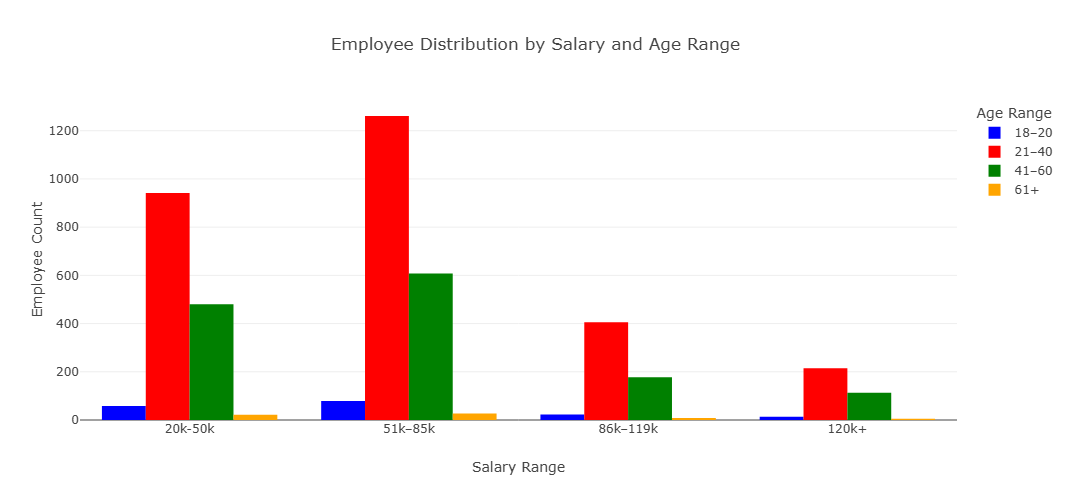

In [36]:
fig = px.bar(
    grouped,
    x='salary_range',
    y='employee_count',
    color='age_range',
    barmode='group',
    title='Employee Distribution by Salary and Age Range',
    labels={
        'salary_range': 'Salary Range',
        'employee_count': 'Employee Count',
        'age_range': 'Age Range'
    },
    height=500,
    color_discrete_map={
        '18–20': 'blue',
        '21–40': 'red',
        '41–60': 'green',
        '61+': 'orange'
    }
)

# Show the chart
fig.show()